# Image Thresholding and Center of Mass Calculation

This notebook demonstrates how to perform image thresholding and calculate the center of mass of the thresholded image. Image thresholding is a technique used to segment an image by setting all pixels below a certain intensity to zero and all pixels above that intensity to a maximum value. The center of mass calculation helps in identifying the geometric center of the thresholded region.

## Load the images and imports

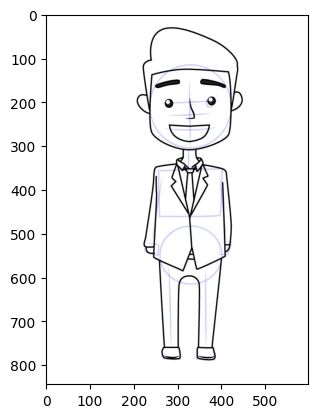

In [13]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

man = cv2.imread("drawings/man.png")
plt.imshow(cv2.cvtColor(man, cv2.COLOR_BGR2RGB))

## Perform a binary threshold on the image
This converts the image to only two colors, allowing the algorithm to classify it more easily

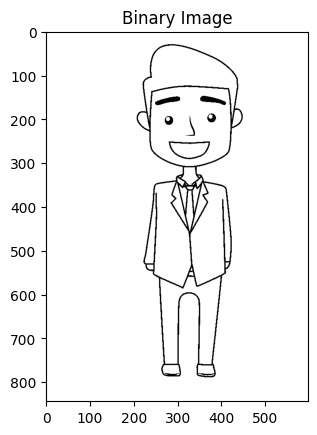

In [37]:
# Convert the image to grayscale
gray_man = cv2.cvtColor(man, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, binary_man = cv2.threshold(gray_man, 127, 255, cv2.THRESH_BINARY)

# Display the binary image
plt.imshow(binary_man, cmap='gray')
plt.title('Binary Image')
plt.show()

## Edge Detection
Find the edges of the binary image using the Sobel operator.

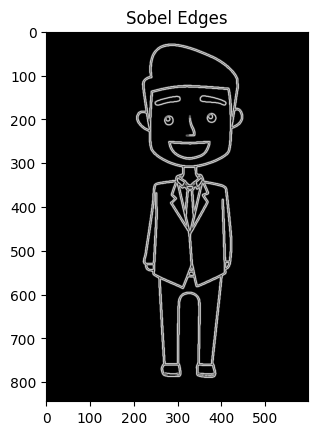

In [38]:
# Apply Sobel operator to find edges
sobelx = cv2.Sobel(binary_man, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(binary_man, cv2.CV_64F, 0, 1, ksize=5)
sobel_edges = np.sqrt(sobelx**2 + sobely**2)

# Display the edges
plt.imshow(sobel_edges, cmap='gray')
plt.title('Sobel Edges')
plt.show()

## Calculate the center of mass
Find the average "center" of the image

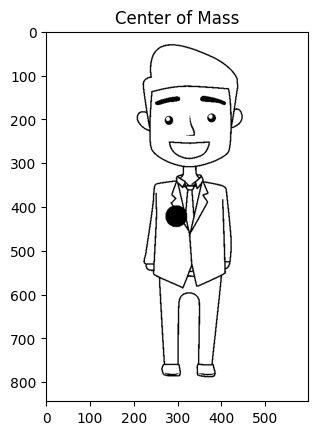

In [39]:
# Calculate the center of mass
com = ndimage.center_of_mass(binary_man)

# Draw a circle at the center of mass
cv2.circle(binary_man, (int(com[1]), int(com[0])), 25, (0, 0, 255), -1)
plt.title('Center of Mass')
plt.imshow(binary_man, cmap='gray')